In [1]:
# data reading and processing

In [3]:
# import math and numpy first
import pandas as pd
import numpy as np
import scipy
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import CategoricalNB
from tabulate import tabulate
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.datasets import make_classification

In [2]:
# read in file
data=pd.read_csv('mbti_1.csv')
data.head()

data[0:10]

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


In [3]:
# basic stats about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8674 entries, 0 to 8673
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8674 non-null   object
 1   posts   8674 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [4]:
# basic stats about each column
data.describe()

,type,posts
count,8674,8674
unique,16,8674
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [5]:
# array of each of the mbti types
mbti_types = data['type'].unique()

# get counts for each of the mbti types
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     684
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

Text(0.5, 0, 'MBTI Types')

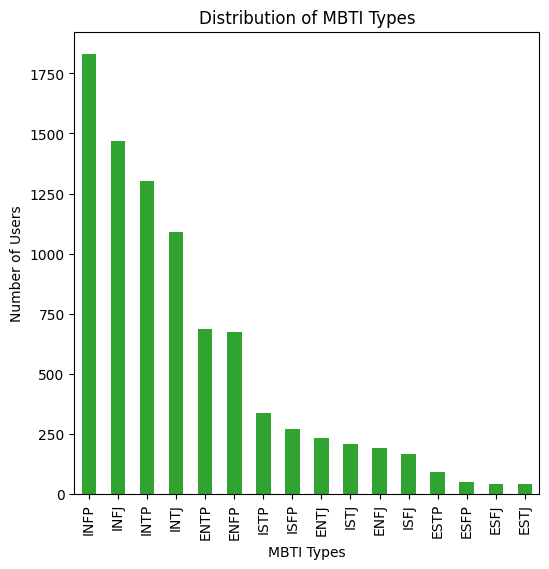

In [6]:
# understanding makeup of dataset in graphical form
data['type'].value_counts().plot(kind="bar", figsize=(6,6),color = (0.1,0.6,0.1,0.9))
plt.title("Distribution of MBTI Types")
plt.ylabel("Number of Users")
plt.xlabel("MBTI Types")

Text(0.5, 0, 'Number of Words per Post')

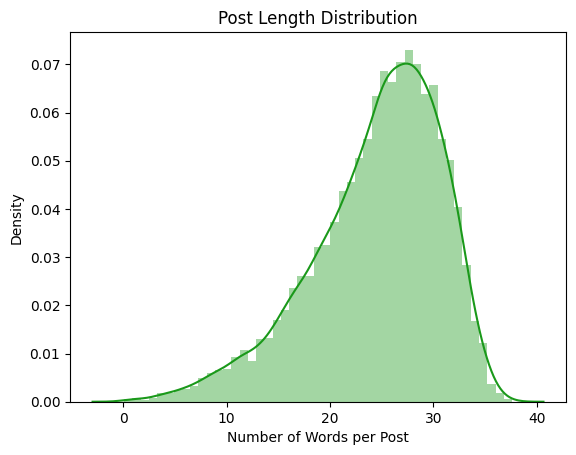

In [8]:
# graphical representation of the distribution of the number of words in all posts
data['posts'].apply(len)

sns.distplot(data['posts'].apply(lambda x: len(x.split())/50),color = (0.1,0.6,0.1,0.9))
plt.title("Post Length Distribution")
plt.ylabel("Density")
plt.xlabel("Number of Words per Post")

Text(0.5, 0, 'Number of Words per 50 Posts')

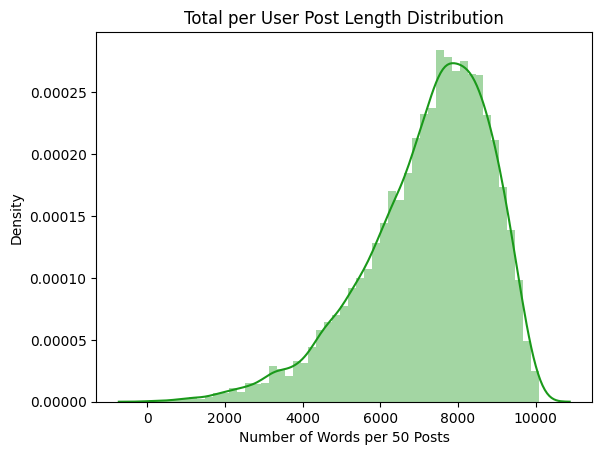

In [9]:
# graphical representation of the distribution of the lengths of the posts
data['posts'].apply(len)
sns.distplot(data['posts'].apply(len),color = (0.1,0.6,0.1,0.9))
plt.title("Total per User Post Length Distribution")
plt.ylabel("Density")
plt.xlabel("Number of Words per 50 Posts")

In [10]:
# NOT REALLY SURE WHAT THIS DOES -> im pretty sure its normalizing data here: getting how many words per comment and dividng it by 50 
data['words_per_comment'] = data['posts'].apply(lambda x: len(x.split())/50)
print(data.head())

   type                                              posts  words_per_comment
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...              11.12
1  ENTP  'I'm finding the lack of me in these posts ver...              23.40
2  INTP  'Good one  _____   https://www.youtube.com/wat...              16.72
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...              21.28
4  ENTJ  'You're fired.|||That's another silly misconce...              19.34


In [11]:
# understand makeup of data prior to pre-processing
data['http_per_comment'] = data['posts'].apply(lambda x: x.count('http'))
data['music_per_comment'] = data['posts'].apply(lambda x: x.count('music'))
data['question_per_comment'] = data['posts'].apply(lambda x: x.count('?'))
data['img_per_comment'] = data['posts'].apply(lambda x: x.count('jpg'))
data['excl_per_comment'] = data['posts'].apply(lambda x: x.count('!'))
data['ellipsis_per_comment'] = data['posts'].apply(lambda x: x.count('...'))
print(data.head())

#plt.figure(figsize=(15,10))
#sns.jointplot(x='words_per_comment', y='ellipsis_per_comment', data=data, kind='kde')

   type                                              posts  words_per_comment  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...              11.12   
1  ENTP  'I'm finding the lack of me in these posts ver...              23.40   
2  INTP  'Good one  _____   https://www.youtube.com/wat...              16.72   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...              21.28   
4  ENTJ  'You're fired.|||That's another silly misconce...              19.34   

   http_per_comment  music_per_comment  question_per_comment  img_per_comment  \
0                24                  1                    18                6   
1                10                  0                     5                1   
2                 5                  0                    12                0   
3                 2                  1                    11                0   
4                 6                  1                    10                2   

   excl_per_comment  ellip

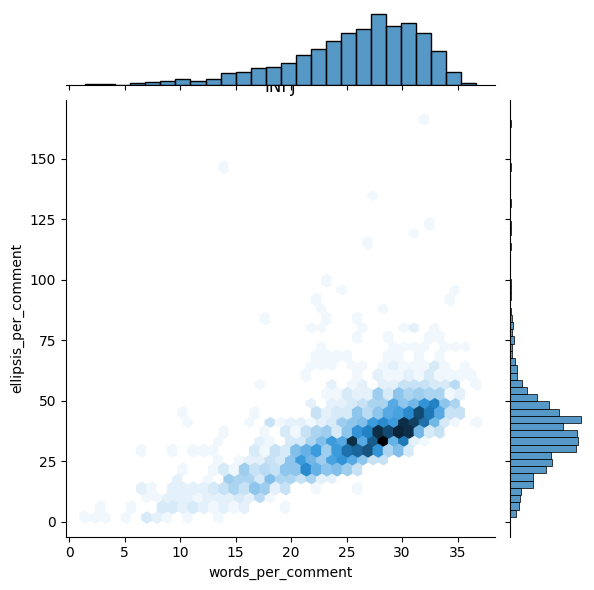

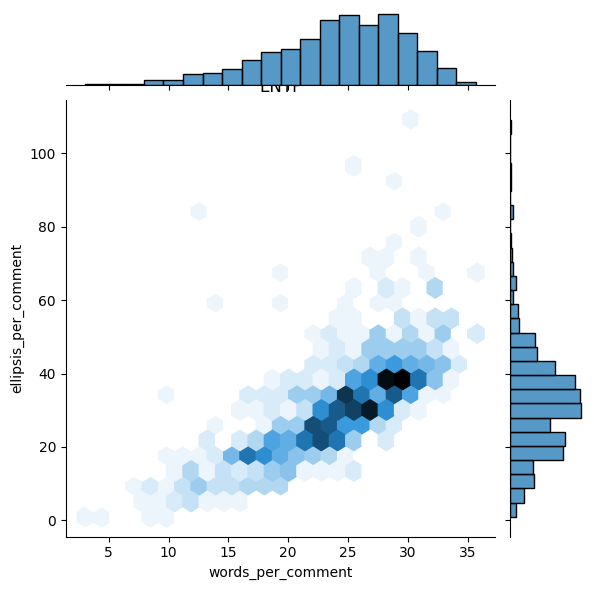

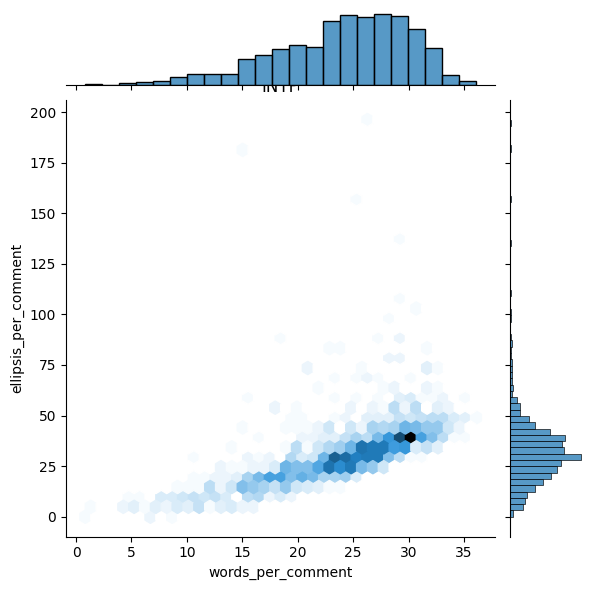

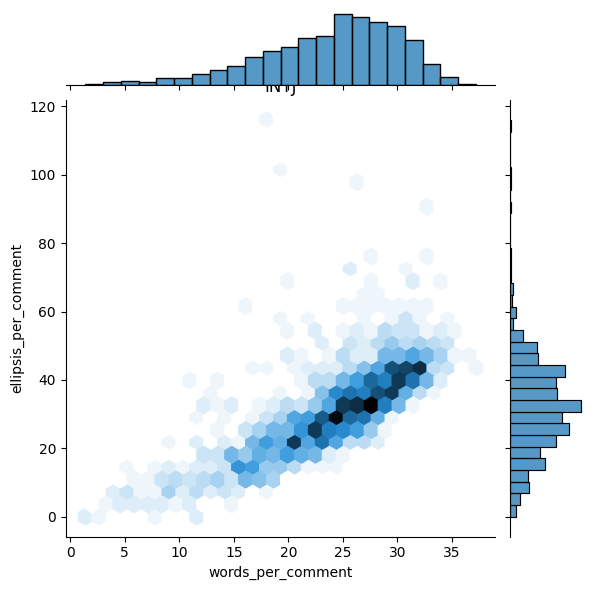

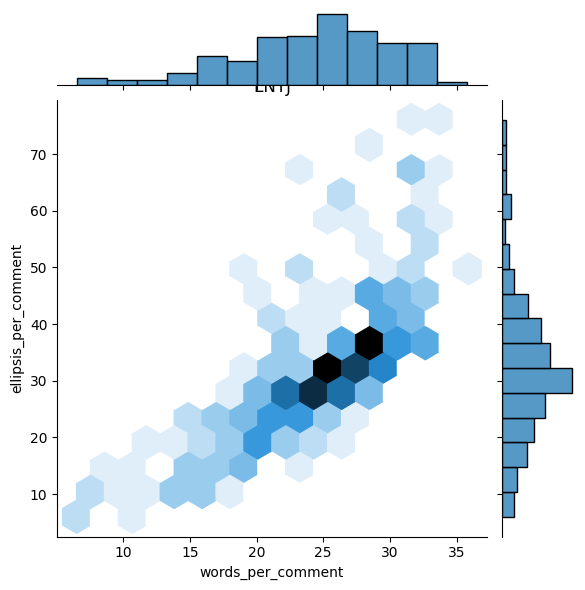

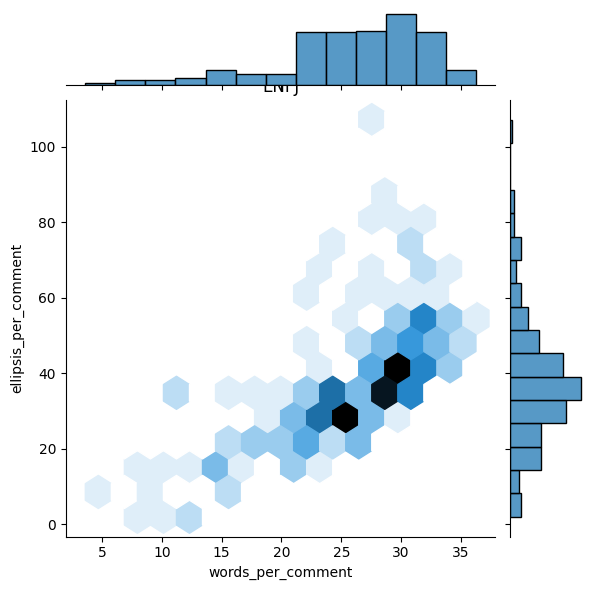

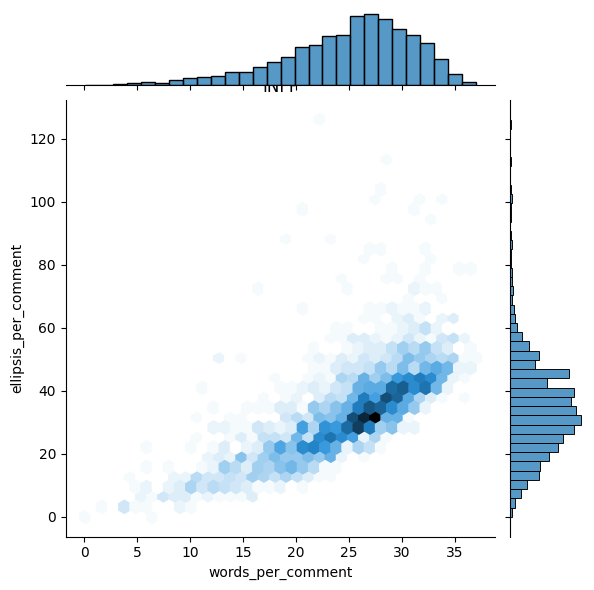

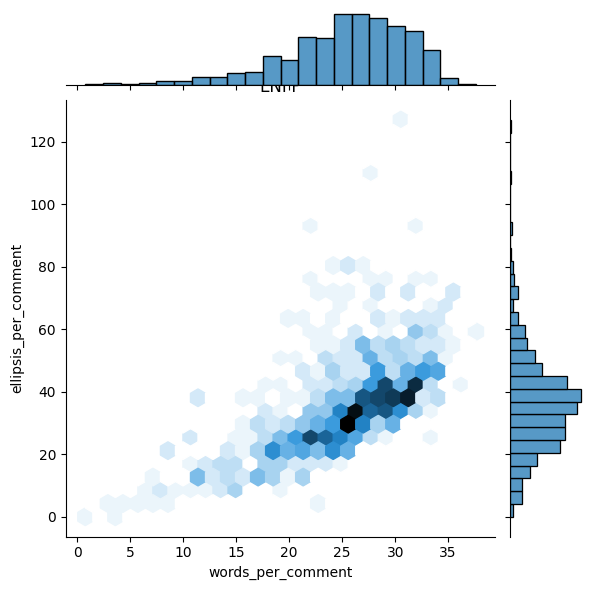

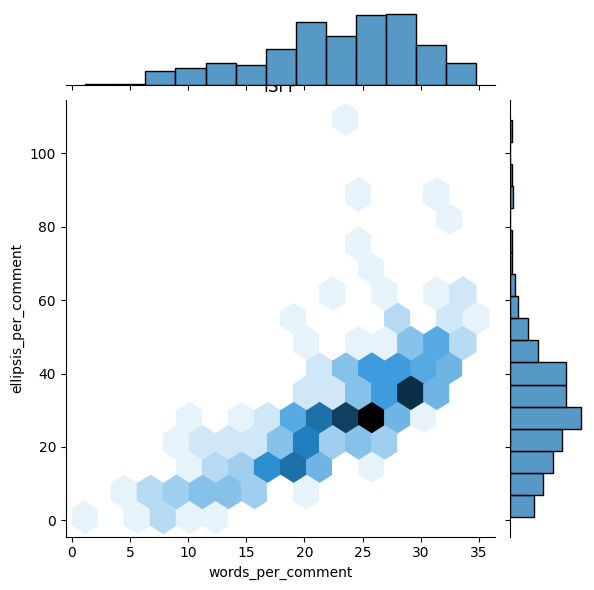

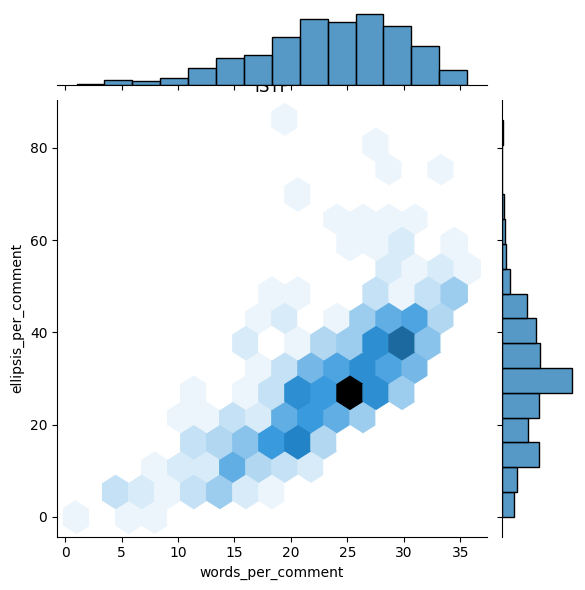

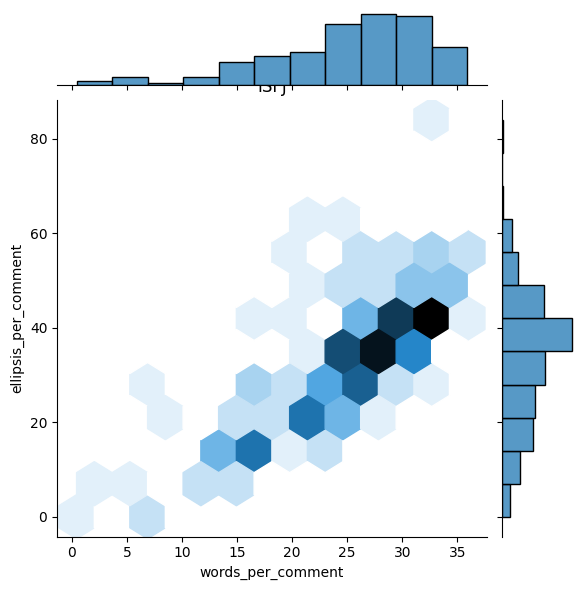

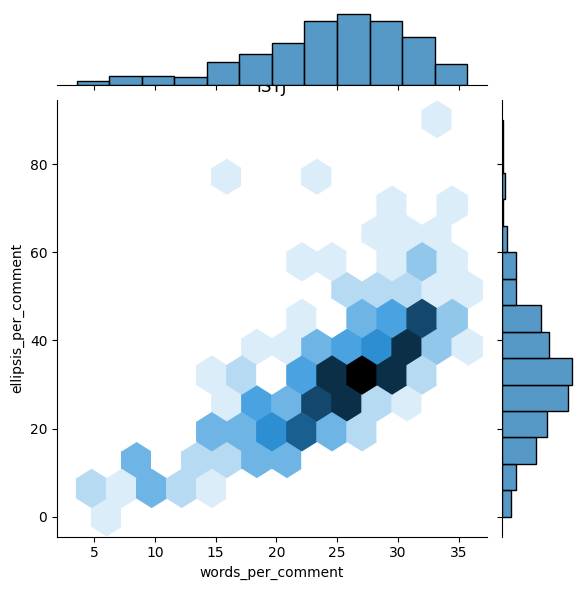

In [12]:
#more exploratory analysis and getting word bag
i = data['type'].unique()
k = 0
for m in range(0,2):
    for n in range(0,6):
        df_2 = data[data['type'] == i[k]]
        sns.jointplot(x='words_per_comment', y='ellipsis_per_comment', data=df_2, kind="hex")
        plt.title(i[k])
        k+=1

0.6399820319539539
0.7054839676052617
0.6417417099995268
0.7418360967765787
0.7423804864273498
0.6701370930896872
0.7223598412495943
0.64210438310988
0.723912910693046
0.7305845421989159
0.760423088098855
0.6974642499076589
[0.760423088098855, 0.7423804864273498, 0.7418360967765787, 0.7305845421989159, 0.723912910693046, 0.7223598412495943, 0.7054839676052617, 0.6974642499076589, 0.6701370930896872, 0.64210438310988, 0.6417417099995268, 0.6399820319539539]
['INFJ', 'INTP', 'ENFP', 'ENFJ', 'ISTJ', 'ENTP', 'INFP', 'ISFP', 'ISTP', 'INTJ', 'ENTJ', 'ISFJ']


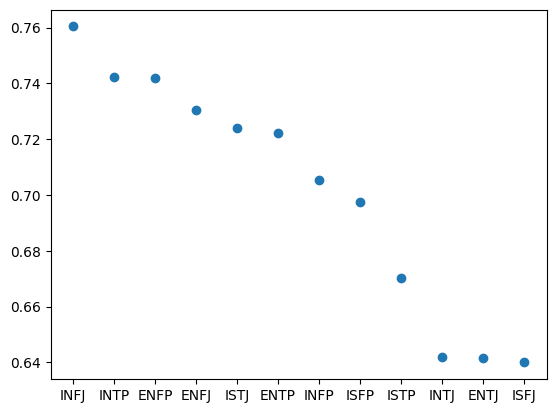

In [13]:
# finding correlation value between words_per_comment and ellipsis_per_comment
i = data['type'].unique()
k = 0
TypeArray = []
PearArray=[]
for m in range(0,2):
    for n in range(0,6):
        df_2 = data[data['type'] == i[k]]
        pearsoncoef1=np.corrcoef(x=df_2['words_per_comment'], y=df_2['ellipsis_per_comment'])
        pear=pearsoncoef1[1][0]
        print(pear)
        TypeArray.append(i[k])
        PearArray.append(pear)
        k+=1

TypeArray = [x for _,x in sorted(zip(PearArray,TypeArray))]
PearArray = sorted(PearArray, reverse=True)
print(PearArray)
print(TypeArray)
plt.scatter(TypeArray, PearArray)

In [14]:
#more data preprocessing: creating 4 new columns diving people by introverted/extroverted, intuition/sensing, and so on (dividing into 4 groups) 
map1 = {"I": 0, "E": 1}
map2 = {"N": 0, "S": 1}
map3 = {"T": 0, "F": 1}
map4 = {"J": 0, "P": 1}
data['I-E'] = data['type'].astype(str).str[0]
data['I-E'] = data['I-E'].map(map1)
data['N-S'] = data['type'].astype(str).str[1]
data['N-S'] = data['N-S'].map(map2)
data['T-F'] = data['type'].astype(str).str[2]
data['T-F'] = data['T-F'].map(map3)
data['J-P'] = data['type'].astype(str).str[3]
data['J-P'] = data['J-P'].map(map4)
print(data.head(10))

   type                                              posts  words_per_comment  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...              11.12   
1  ENTP  'I'm finding the lack of me in these posts ver...              23.40   
2  INTP  'Good one  _____   https://www.youtube.com/wat...              16.72   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...              21.28   
4  ENTJ  'You're fired.|||That's another silly misconce...              19.34   
5  INTJ  '18/37 @.@|||Science  is not perfect. No scien...              29.82   
6  INFJ  'No, I can't draw on my own nails (haha). Thos...              26.58   
7  INTJ  'I tend to build up a collection of things on ...              24.46   
8  INFJ  I'm not sure, that's a good question. The dist...              14.76   
9  INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...              24.66   

   http_per_comment  music_per_comment  question_per_comment  img_per_comment  \
0                24        

In [15]:
# Dataset cleaning - removing links, symbols, MBTI types and making lowercase
def text_cleaning(data):
    # removing links from text data
    data['posts'] = data['posts'].apply(lambda x: re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+'," ",x.replace("|"," ") + " "))
    
    # removing other symbols
    data['posts'] = data['posts'].apply(lambda x: re.sub('[^0-9a-z]'," ",x.replace("|"," ") + " "))
    
    # making all words lowercase
    data['posts'] = data['posts'].apply(lambda x: x.lower())
    
    # removing any mention of MBTI types
    for type in mbti_types:
        data['posts'] = data['posts'].str.replace(type.lower(),' ', regex=False)
    
text_cleaning(data)
print(data.head())

   type                                              posts  words_per_comment  \
0  INFJ             and   moments     sportscenter not ...              11.12   
1  ENTP     m finding the lack of me in these posts ver...              23.40   
2  INTP    ood one               f course  to which   s...              16.72   
3  INTJ    ear           enjoyed our conversation the o...              21.28   
4  ENTJ    ou re fired     hat s another silly misconce...              19.34   

   http_per_comment  music_per_comment  question_per_comment  img_per_comment  \
0                24                  1                    18                6   
1                10                  0                     5                1   
2                 5                  0                    12                0   
3                 2                  1                    11                0   
4                 6                  1                    10                2   

   excl_per_comment  ellip

In [16]:
# #redefine dataset 
# X, y = make_classification(n_samples = 10000, weights = [0.99] , flip_y = 0)

# #oversampling strategy
# oversample = RandomOverSampler(sampling_strategy = 'minority')

# #fit and apply the transform
# X_over , y_over = oversample.fit_resample(X, y)

# #summarize class distribution
# print(Counter(y_over))

In [17]:
vect = CountVectorizer(stop_words = 'english')
X = vect.fit_transform(data["posts"])
data['type_num'] = LabelEncoder().fit_transform(data['type'])
y = data['type_num']

print(data.head())
print(y)
print(X.shape)

# #train and test split 
# X = data.drop(['type','posts','I-E','N-S','T-F','J-P'], axis=1).values
# y = data['type'].values

# print(X.shape)
# print(y.shape)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.1, stratify=y, random_state=42)

   type                                              posts  words_per_comment  \
0  INFJ             and   moments     sportscenter not ...              11.12   
1  ENTP     m finding the lack of me in these posts ver...              23.40   
2  INTP    ood one               f course  to which   s...              16.72   
3  INTJ    ear           enjoyed our conversation the o...              21.28   
4  ENTJ    ou re fired     hat s another silly misconce...              19.34   

   http_per_comment  music_per_comment  question_per_comment  img_per_comment  \
0                24                  1                    18                6   
1                10                  0                     5                1   
2                 5                  0                    12                0   
3                 2                  1                    11                0   
4                 6                  1                    10                2   

   excl_per_comment  ellip

In [18]:
#SMOTE algorithm to handle class imbalance
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print("Before: " , counter)

#oversampling the train dataset using SMOTE
smt = SMOTE()

X_train, y_train = smt.fit_resample(X_train, y_train)

counter = Counter(y_train)
print("After: " , counter)

Before:  Counter({9: 1649, 8: 1323, 11: 1174, 10: 982, 3: 616, 1: 607, 15: 303, 13: 244, 2: 208, 14: 184, 0: 171, 12: 149, 7: 80, 5: 43, 4: 38, 6: 35})
After:  Counter({0: 1649, 8: 1649, 10: 1649, 3: 1649, 9: 1649, 11: 1649, 1: 1649, 15: 1649, 4: 1649, 14: 1649, 6: 1649, 12: 1649, 2: 1649, 7: 1649, 13: 1649, 5: 1649})


In [19]:
# #train and test split 
# X = data.drop(['type','posts','I-E','N-S','T-F','J-P'], axis=1).values
# y = data['type'].values

# print(X.shape)
# print(y.shape)

# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.1, random_state=5)

#linear support vector machine classifier using SGD training
svm = SGDClassifier(max_iter=5, tol=None)
svm.fit(X_train, y_train)
Y_pred = svm.predict(X_test)
svm.score(X_train, y_train)
acc_svm = round(svm.score(X_train, y_train) * 100, 2)
print(round(acc_svm,2,), "%")

91.67 %


In [20]:
# Decision Tree
decision_tree = DecisionTreeClassifier(max_depth = 10)
decision_tree.fit(X_train,y_train)

Y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print(round(acc_decision_tree,2,), "%")

17.33 %


In [21]:
# Random Forest - ensemble of decision trees
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

99.97 %


In [22]:
# Logistic Regression
logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print(round(acc_log,2,), "%")

99.15 %


In [23]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, y_train) * 100, 2)
print(round(acc_knn,6,), "%")

89.93 %


In [24]:
#Naive Bayes
NB = CategoricalNB()
# y_pred = NB.fit(X_train.toarray(), y_train).predict(X_test.toarray())
# print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
NB.fit(X_train.toarray(), y_train)
acc_nb = round(NB.score(X_train.toarray(), y_train) * 100, 2)
print(round(acc_nb,2,), "%")

68.83 %


In [25]:
#Repeated hold-out validation and Computing Statistics
for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.4, random_state=i)
    treeB = RandomForestClassifier(n_estimators = 100)
    treeB.fit(X_train,y_train)
    print(treeB.score(X_test,y_test))

0.25360230547550433
0.26051873198847264
0.2642651296829971
0.2564841498559078
0.26570605187319885
0.24927953890489912
0.26368876080691644
0.2659942363112392
0.25878962536023054
0.2365994236311239


In [26]:
#random seed
myList = []
for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.4)
    treeB = RandomForestClassifier(n_estimators = 100)
    treeB.fit(X_train,y_train)
    print(treeB.score(X_test,y_test))
    myList.append(treeB.score(X_test,y_test))
print(myList)

0.2489913544668588
0.2642651296829971
0.2397694524495677
0.26455331412103744
0.2524495677233429
0.24293948126801151
0.2734870317002882
0.2501440922190202
0.2576368876080692
0.2559077809798271
[0.2489913544668588, 0.2642651296829971, 0.2397694524495677, 0.26455331412103744, 0.2524495677233429, 0.24293948126801151, 0.2734870317002882, 0.2501440922190202, 0.2576368876080692, 0.2559077809798271]


In [27]:
#compute mean
sum = 0
for i in range(len(myList)):
    sum += myList[i]
    
mean = sum/len(myList)
print("mean: " , mean)

mean:  0.255014409221902


In [28]:
#variance and standard deviation
diff = 0
for i in range(len(myList)):
    diff += pow((myList[i]-mean), 2)

var = (1/(len(myList)-1))*diff
standDev = np.sqrt(var)
print("variance: " , var)
print("standard deviation: ", standDev)

variance:  0.00010780755591359458
standard deviation:  0.010383041746694202


In [29]:
#stats using scipy
scipy.stats.describe(myList)

DescribeResult(nobs=10, minmax=(0.2397694524495677, 0.2734870317002882), mean=0.255014409221902, variance=0.00010780755591359458, skewness=0.24351591932178396, kurtosis=-0.7768879116016745)

In [30]:
#start k-fold cross-validation 
clf = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
scores = cross_val_score(clf,X,y,cv=5)
print(scores)

[0.16368876 0.14697406 0.16253602 0.16023055 0.15570934]


In [31]:
#statistics on the accuracies
print('mean accuracy:', scores.mean(), ', stdDev:', scores.std())

mean accuracy: 0.15782774747464673 , stdDev: 0.006075901279370246


In [32]:
#Repeated K-fold (aka N-by-K fold)
rkf = RepeatedKFold(n_splits = 5, n_repeats = 3)
scores2 = cross_val_score(clf, X,y, cv = rkf)
scores2

array([0.14985591, 0.14293948, 0.17694524, 0.16945245, 0.15340254,
       0.14697406, 0.15273775, 0.16426513, 0.15677233, 0.16089965,
       0.15389049, 0.16195965, 0.16541787, 0.14870317, 0.16724337])

In [33]:
print('mean accuracy:', scores2.mean(), ', stdDev:', scores2.std())

mean accuracy: 0.1580972736045879 , stdDev: 0.00917283389788883


In [34]:
from sklearn.metrics import precision_recall_curve
y_prob_train = clf.predict_proba(X_train)[:,1]
precision, recall, thresholds = precision_recall_curve(y_train, y_prob_train)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve");

NotFittedError: This KNeighborsClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
#Try using N-by-K to compare some classifiers
rkf = RepeatedKFold(n_splits = 10, n_repeats = 10)

nn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
dt = DecisionTreeClassifier()

nnScores = cross_val_score(nn,X,y,cv = rkf)
dtScores = cross_val_score(dt,X,y,cv = rkf)

print('Nearest Neighbor: mean =', nnScores.mean(), ', stdDev =', nnScores.std())
print('Decision Tree: mean =', dtScores.mean(), ', stdDev =', dtScores.std())
print('Difference between means:', dtScores.mean() - nnScores.mean())
scipy.stats.mannwhitneyu(nnScores, dtScores)

In [ ]:
def runTuneTest(learner, parameters, X,y):
    """
    The purpose of this function is to take a base learner passed in from runPipeline, a dictionary of hypermarameters to tune, and the data in order to handle creating train/tune/test sets. It performs end-to-end training and 
    evaluation. It then returns a list of accuracy scores for each fold from the stratified k fold.
    param learner: base learner to be used
    param paramater: dictionary mapping string names of hypermarameters to a list of values to try for that hyperparameter
    param X and y: data
    return: list of accuracy scores for each fold
    """
    scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
    for train, test in skf.split(X, y):
        model = GridSearchCV(learner, parameters, cv=3) #use 3 folds for tuning
        model.fit(X[train], y[train])
        scores.append(model.score(X[test],y[test]))
    return scores

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import tree 

def runPipeline(X,y):
    """
    The purpose of this function is to call runTuneTest.
    Parameter X,y: mbtiDataset data and target 
    return: returns the result from running runTuneTest
    """   
    #random forest classifier
    clf = RandomForestClassifier()
    parameters = {"n_estimators" : [200], "max_features" : [0.01, 0.1, 0.5, 1.0, "sqrt"]} 
    results = runTuneTest(clf, parameters, X, y)
    
    #decision tree classifier
    clf2 = DecisionTreeClassifier()
    parameters2 = {"max_depth" : [50], "max_features" : [0.01, 0.1, 0.5, 1.0, "sqrt"]} 
    results2 = runTuneTest(clf2, parameters2, X, y)

    #print accuracy results
    print("Fold, RF, DT")
    for i in range(len(results)):
        print(i, str(f'{results[i]:.3f}'), str(f'{results2[i]:.3f}'))
        
    final_result = (results, results2) 
    return final_result 

In [ ]:
runPipeline(X,y)

In [ ]:
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
%matplotlib inline
import matplotlib.pyplot as plt

def print_results(method, k_range, train_accuracy, test_accuracy):
    if method == "SVM":
        print("Max Depth, Train Accuracy, Test Accuracy")
        for i in range(len(k_range)):
            print(k_range[i], str(f'{train_accuracy[i]:.3f}'), str(f'{test_accuracy[i]:.3f}'))
            
    elif method == "RF":
        print("Trees, Train Accuracy, Test Accuracy")
        for i in range(len(k_range)):
            print(k_range[i], str(f'{train_accuracy[i]:.3f}'), str(f'{test_accuracy[i]:.3f}'))
            
def plot_data(method, k_range, train_accuracy, test_accuracy):
    if method == "SVM":
        plt.title("SVM Validation Curve", fontsize="xx-large")
        plt.xlabel("max_depth",fontsize="large")
        plt.ylabel("Accuracy",fontsize="large")
        plt.ylim(0.0, 1.1)
        plt.xticks(k_range)

        plt.plot(k_range, train_accuracy, label="Training score", color="darkorange")
        plt.plot(k_range, test_accuracy, label="Cross-validation score", color="navy")

        plt.legend(loc="best")
        plt.show()
        
    elif method == "RF":
        plt.title("Random Forest Validation Curve", fontsize="xx-large")
        plt.xlabel("n_estimators",fontsize="large")
        plt.ylabel("Accuracy",fontsize="large")
        plt.ylim(0.0, 1.1)
        plt.xticks(k_range)

        plt.plot(k_range, train_accuracy, label="Training score", color="darkorange")
        plt.plot(k_range, test_accuracy, label="Cross-validation score", color="navy")

        plt.legend(loc="best")
        plt.show()
            
def generateCurves(dataSetName,method):
    """
    The purpose of this function is to generate validation curves in order to visualize the impact of hyperparameters on the model.
    param X,y: mbtiDataset data and target 
    param method: method to be used
    """
    
    #random forest classifier
    if method == "RF" :
        #create Random Forests classifier and run train/tune/test pipeline 
        forestB = RandomForestClassifier(n_estimators = 201)
        paramForest = {"n_estimators":[1,51,101,151,201]}
        train_scores, test_scores = validation_curve(forestB, X, y, param_name="n_estimators", param_range=paramForest["n_estimators"],cv=5,n_jobs=3)
        # rf_range = np.arange(1, 201, 10).astype('int')
        rf_range = np.arange(1, 201, 10, dtype = int)
        #rf_range = [1,11,21,31,41,51,61,71,81,91,101,111,121,131,141,151,161,171,181,191,201]
        printPretty(train_scores, test_scores, ['Estimators', 'Train Accuracy', 'Test Accuracy'], rf_range)
        plt.title("RF Validation Curve", fontsize="xx-large")
        plt.xlabel("n_estimators",fontsize="large")
        plotCurve(train_scores, test_scores, paramForest["n_estimators"])

    #k-nearest neighbor 
    elif method == "KNN":
        #create KNN classifier and run train/tune/test pipeline
        classifierB = KNeighborsClassifier(metric='euclidean',n_neighbors=1)
        parameters = {"weights":["uniform","distance"], "n_neighbors":[1,5,11]}
        train_scores, test_scores = validation_curve(KNeighborsClassifier(), X, y, param_name="n_neighbors", param_range=parameters["n_neighbors"],cv=5,n_jobs=3)
        # knn_range = np.arange(1, 12, 1).astype('int')
        knn_range = np.arange(1, 12, 1, dtype = int)
        
        printPretty(train_scores, test_scores, ['Neighbors', 'Train Accuracy', 'Test Accuracy'], knn_range)
        plt.title("KNN Validation Curve", fontsize="xx-large")
        plt.xlabel("n_neighbors",fontsize="large")
        plotCurve(train_scores, test_scores, parameters["n_neighbors"])

    #linear support vector machine classifier
    elif method == "SVM":
        svm2 = SGDClassifier(max_iter=5, tol=None)
        k_range2 = np.arange(1, 50, 5).astype('int') #max_depth range
        
        #generate the data for validation curves 
        train_scores2, test_scores2 = validation_curve(svm2, X, y, param_name="max_depth", param_range=k_range2, cv=3) 
        train_scores_mean2 = np.mean(train_scores2, axis=1)
        test_scores_mean2 = np.mean(test_scores2, axis=1)

        #print results and graph
        print("-------")
        print_results(method, k_range2, train_scores_mean2, test_scores_mean2)
        plot_data(method, k_range2, train_scores_mean2, test_scores_mean2)
        
# A helper function to print a table of the parameter value, train accuracies, and test accuracies
def printPretty(train_scores, test_scores, header, clf_range):
    prettyList = []
    k = 0
    for i in range(len(test_scores)-1):
        for j in range(len(test_scores[i])):
            prettyList.append([clf_range[k], np.round(train_scores[i][j],3), np.round(test_scores[i][j],3)])
            k += 1
    
    print(tabulate(prettyList,headers=header))
    print(" ")
    
# A helper function to plot the accuracies
def plotCurve(train_scores, test_scores, range):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.ylabel("Accuracy",fontsize="large")
    plt.ylim(0.0, 1.1)
    plt.xticks(range)
    plt.plot(range, train_scores_mean, label="Training score", color="darkorange")
    plt.plot(range, test_scores_mean, label="Cross-validation score", color="navy")

    plt.legend(loc="best")
    plt.show()

In [ ]:
generateCurves("mbti","RF")

In [ ]:
generateCurves("mbti","SVM")

In [ ]:
generateCurves("mbti","KNN")